## Overview

In this project, we have a dataset containing information about the company's clients. Our task is to segment these clients into different groups so that we can implement tailored business strategies for each type of customer. We will be using the K-means algorithm for this analysis. The company expects to receive a distinct group for each client, along with a detailed explanation of the characteristics that define each group and their main differences.

### Importing libraries for data collectio nand analysis

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Collection

Source: dataquest.io

### Data Dictionary

- `customer_id`: unique identifier for each customer.
- `age`: customer age in years.
- `gender`: customer gender (M or F).
- `dependent_count`: number of dependents of each customer.
- `education_level`: level of education ("High School", "Graduate", etc.).
- `marital_status`: marital status ("Single", "Married", etc.).
- `estimated_income`: the estimated income for the customer projected by the data science team.
- `months_on_book`: time as a customer in months.
- `total_relationship_count`: number of times the customer contacted the company.
- `months_inactive_12_mon`: number of months the customer did not use the credit card in the last 12 months.
- `credit_limit`: customer's credit limit.
- `total_trans_amount`: the overall amount of money spent on the card by the customer.
- `total_trans_count`: the overall number of times the customer used the card.
- `avg_utilization_ratio`: daily average utilization ratio.

### Exploratory Data Analysis

In [2]:
customer_data = pd.read_csv("./Datasets/customer_segmentation.csv")
customer_data.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [3]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

The customer segmentation dataset contains 10127 records and includes 14 features, along with a unique identifier for each customer. All columns, except for the customer_id, can be further analyzed as criteria for grouping customers. Notably, the dataset does not have any null values.

Out of the 13 columns (excluding customer_id), there are eight integer features, two float features, and three categorical features. In total, there are 10 numeric features and three categorical features.

In [4]:
for col in customer_data.select_dtypes(include="object"):
    print(customer_data[col].value_counts(), end="\n\n")

gender
F    5358
M    4769
Name: count, dtype: int64

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64



This output allows us to examine the values associated with each category within the categorical features. Subsequently, we will assess the correlation between the numerical columns and illustrate the distribution of their values through appropriate visualizations.

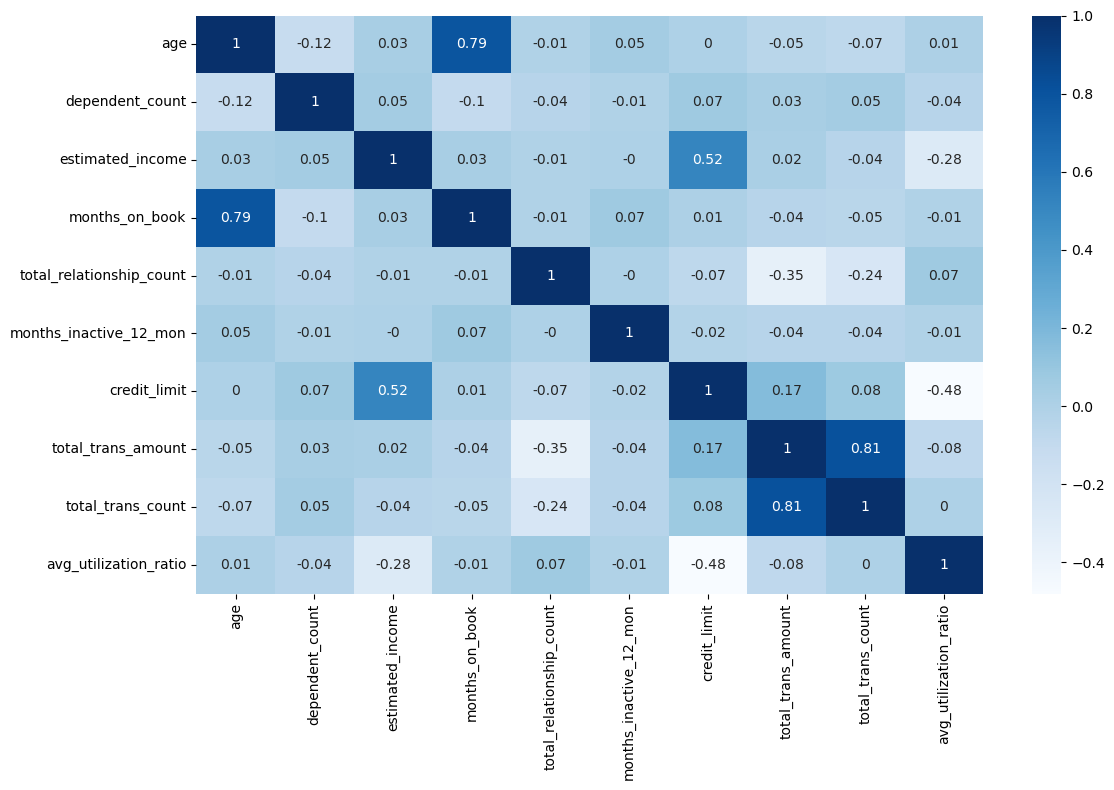

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(round(customer_data.drop("customer_id", axis=1).corr(numeric_only=True), 2), cmap="Blues", annot=True, ax=ax)
plt.tight_layout()
plt.show()

After analyzing the heatmap, several correlations among features were identified:

- **Age and Months on Book (0.79)**: This positive correlation indicates that older customers tend to remain customers for a longer duration.
- **Credit Limit and Estimated Income (0.52)**: This positive correlation suggests that as estimated income increases, the credit limit also tends to increase.
- **Total Transaction Count and Total Transaction Amount (0.81)**: This strong positive correlation implies that the more transactions a customer makes, the higher their total spending.
- **Credit Limit and Average Utilization Ratio (-0.48)**: This negative correlation indicates that an increase in credit limit is typically associated with a decrease in the utilization ratio. In other words, if the credit limit goes up, a customer's utilization may likely decrease.

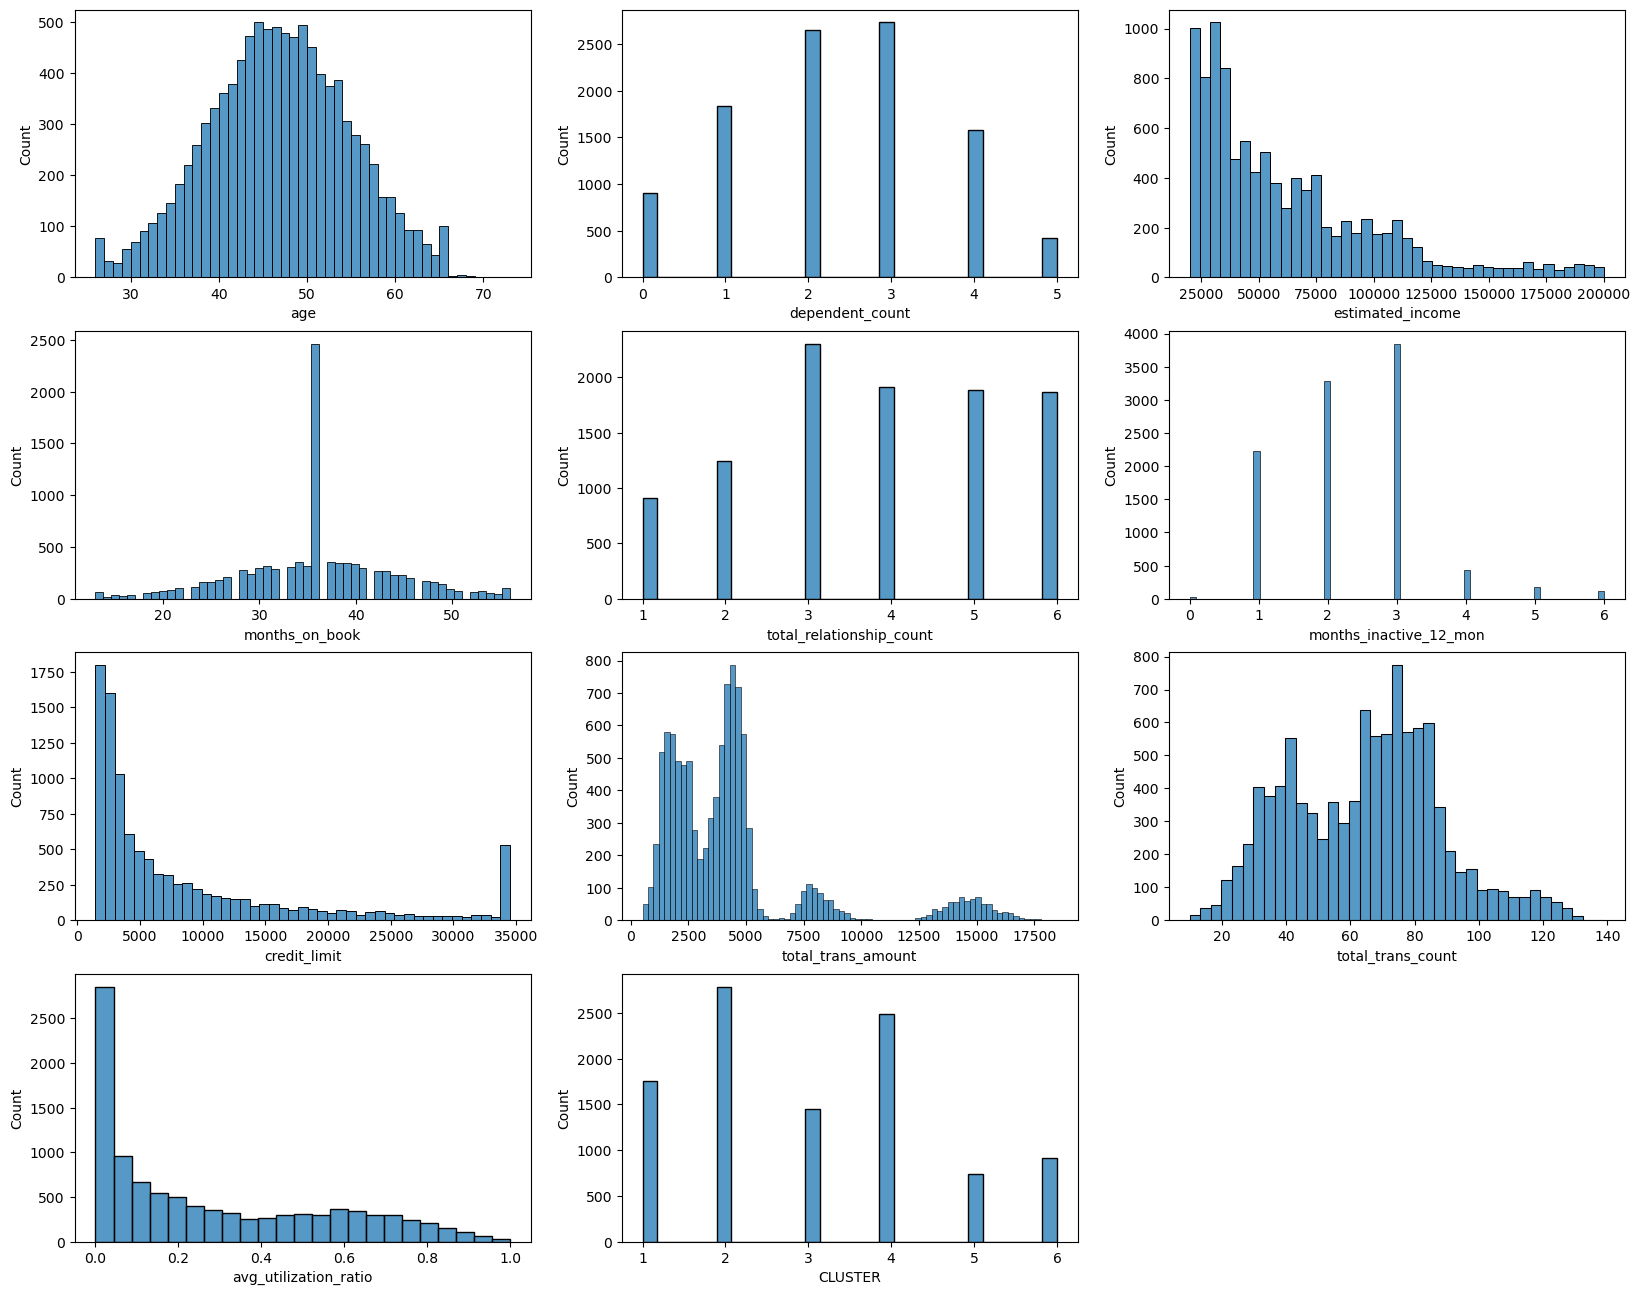

In [39]:
numerical_columns = customer_data.select_dtypes(exclude="object").drop("customer_id", axis=1)
fig = plt.figure(figsize=(20,16))
for idx, col in enumerate(numerical_columns.columns):
    ax = plt.subplot(4, 3, idx+1)
    sns.histplot(x=customer_data[col], ax=ax)

Our numerical fields are on various scales. Some of our distrubtions are normal, but most of them are skewed. 

### Feature Engineering

#### Categorical variables

`gender` and `marital_satus` are nominal, but `education_level` is ordinal. For the categorical fields, we can perform the following:

- Map `gender` to 1 and 0s
- Map `education_level` by using an increasing integer to reflect order
- Dummify `marital_status`

In [7]:
customer_data_copy = customer_data.copy()

In [8]:
# gender mapping
gen_mapping = {
    "M": 1,
    "F": 0,
}

# education mapping
ed_mappings = {
    "Uneducated": 0,
    "High School": 1,
    "College": 2,
    "Graduate": 3,
    "Post-Graduate": 4,
    "Doctorate": 5
}
customer_data_copy["gender"] = customer_data_copy["gender"].map(gen_mapping)
customer_data_copy["education_level"] = customer_data_copy["education_level"].map(ed_mappings)
print(customer_data_copy["education_level"].value_counts()) # aligns with previous value count output above

education_level
3    3685
1    2351
0    1755
2    1192
4     616
5     528
Name: count, dtype: int64


In [9]:
marital_df = pd.get_dummies(customer_data_copy["marital_status"], drop_first=True)
customer_data_copy = customer_data_copy.join(marital_df)
customer_data_copy.drop("marital_status", axis=1, inplace=True)
customer_data_copy.head()

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,Married,Single,Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,True,False,False
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,False,True,False
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,True,False,False
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,False,False,True
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,True,False,False


#### Scaling the numerical features

As illustrated in the distribution plots, our numerical features are on varying scales, and standardizing them will enhance the performance of our clustering algorithm. In the following section, we will standardize our numerical features before determining the optimal number of clusters.

In [10]:
X = customer_data_copy.drop("customer_id", axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X)
X = pd.DataFrame(ss.transform(X))

### Choosing K
In this section we will run the k-means algorithm using a range from 1 to 10. Then, we will plot the elbow curve to aid in finding the final K. 

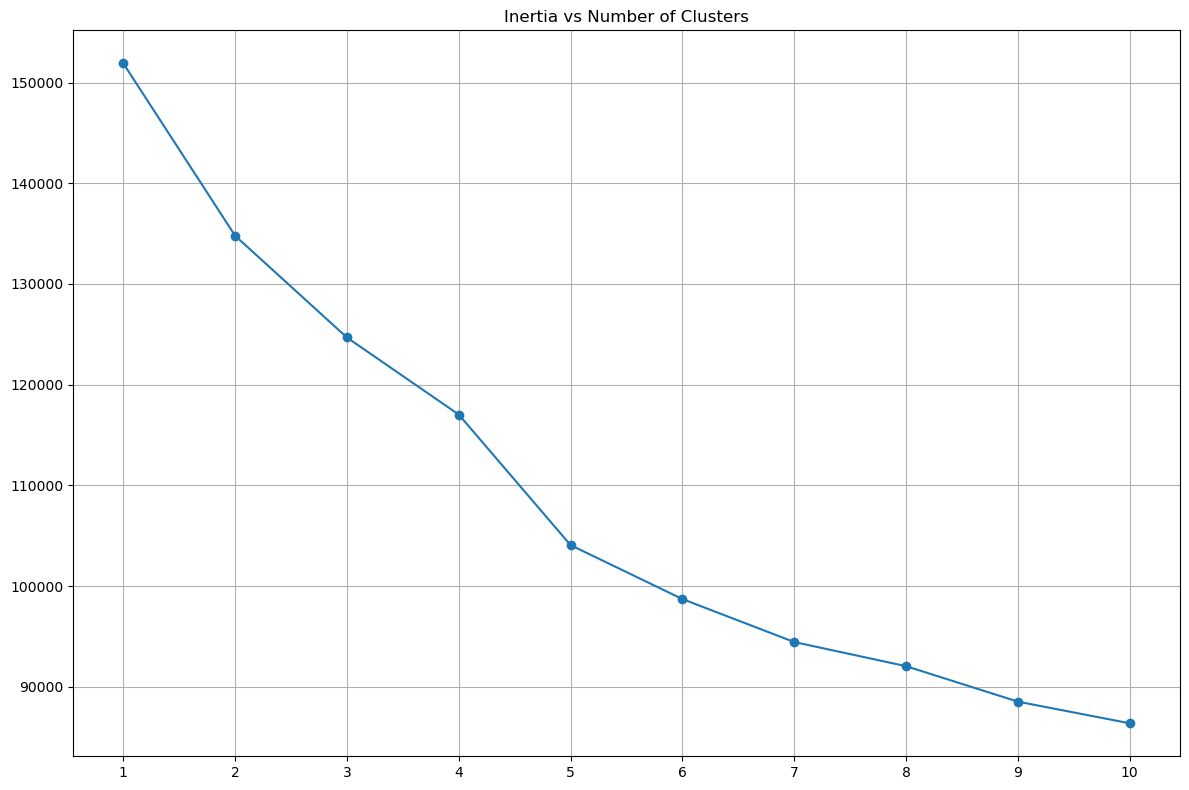

In [12]:
from sklearn.cluster import KMeans

def plot_elbow_curve(df, max_clusters=10):
    inertias = []
    for i in range(1, max_clusters):
        model = KMeans(n_clusters=i)
        model.fit_predict(df)
        inertias.append(model.inertia_)

    plt.figure(figsize=(12,8))
    plt.plot(range(1, max_clusters), inertias, marker="o")
    plt.xticks(ticks=range(1, max_clusters), labels=range(1,max_clusters))
    plt.title("Inertia vs Number of Clusters")
    plt.grid()
    plt.tight_layout()
    plt.show()
    return inertias

inertias = plot_elbow_curve(X, 11)


Intertia decreasing is observed to slow between 5 and 7 clusters. We'll use 6 clusters for final analysis.

In [13]:
final_model = KMeans(n_clusters=6)
y = final_model.fit_predict(X)
print(y)

[0 3 0 ... 1 4 1]


## Analyzing Results

In [14]:
customer_data["CLUSTER"] = y + 1
customer_data

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,1
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,4
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,1
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,5
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,6
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,2
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,2
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,5


In [16]:
customer_data["CLUSTER"].value_counts()

CLUSTER
2    2788
4    2491
1    1756
3    1448
6     910
5     734
Name: count, dtype: int64

Cluster 2 is identified as the largest, while cluster 5 is the smallest. To conduct a thorough analysis of the numeric features associated with each cluster, we will calculate the average value for each feature and present the findings in bar charts for clarity and effective communication.

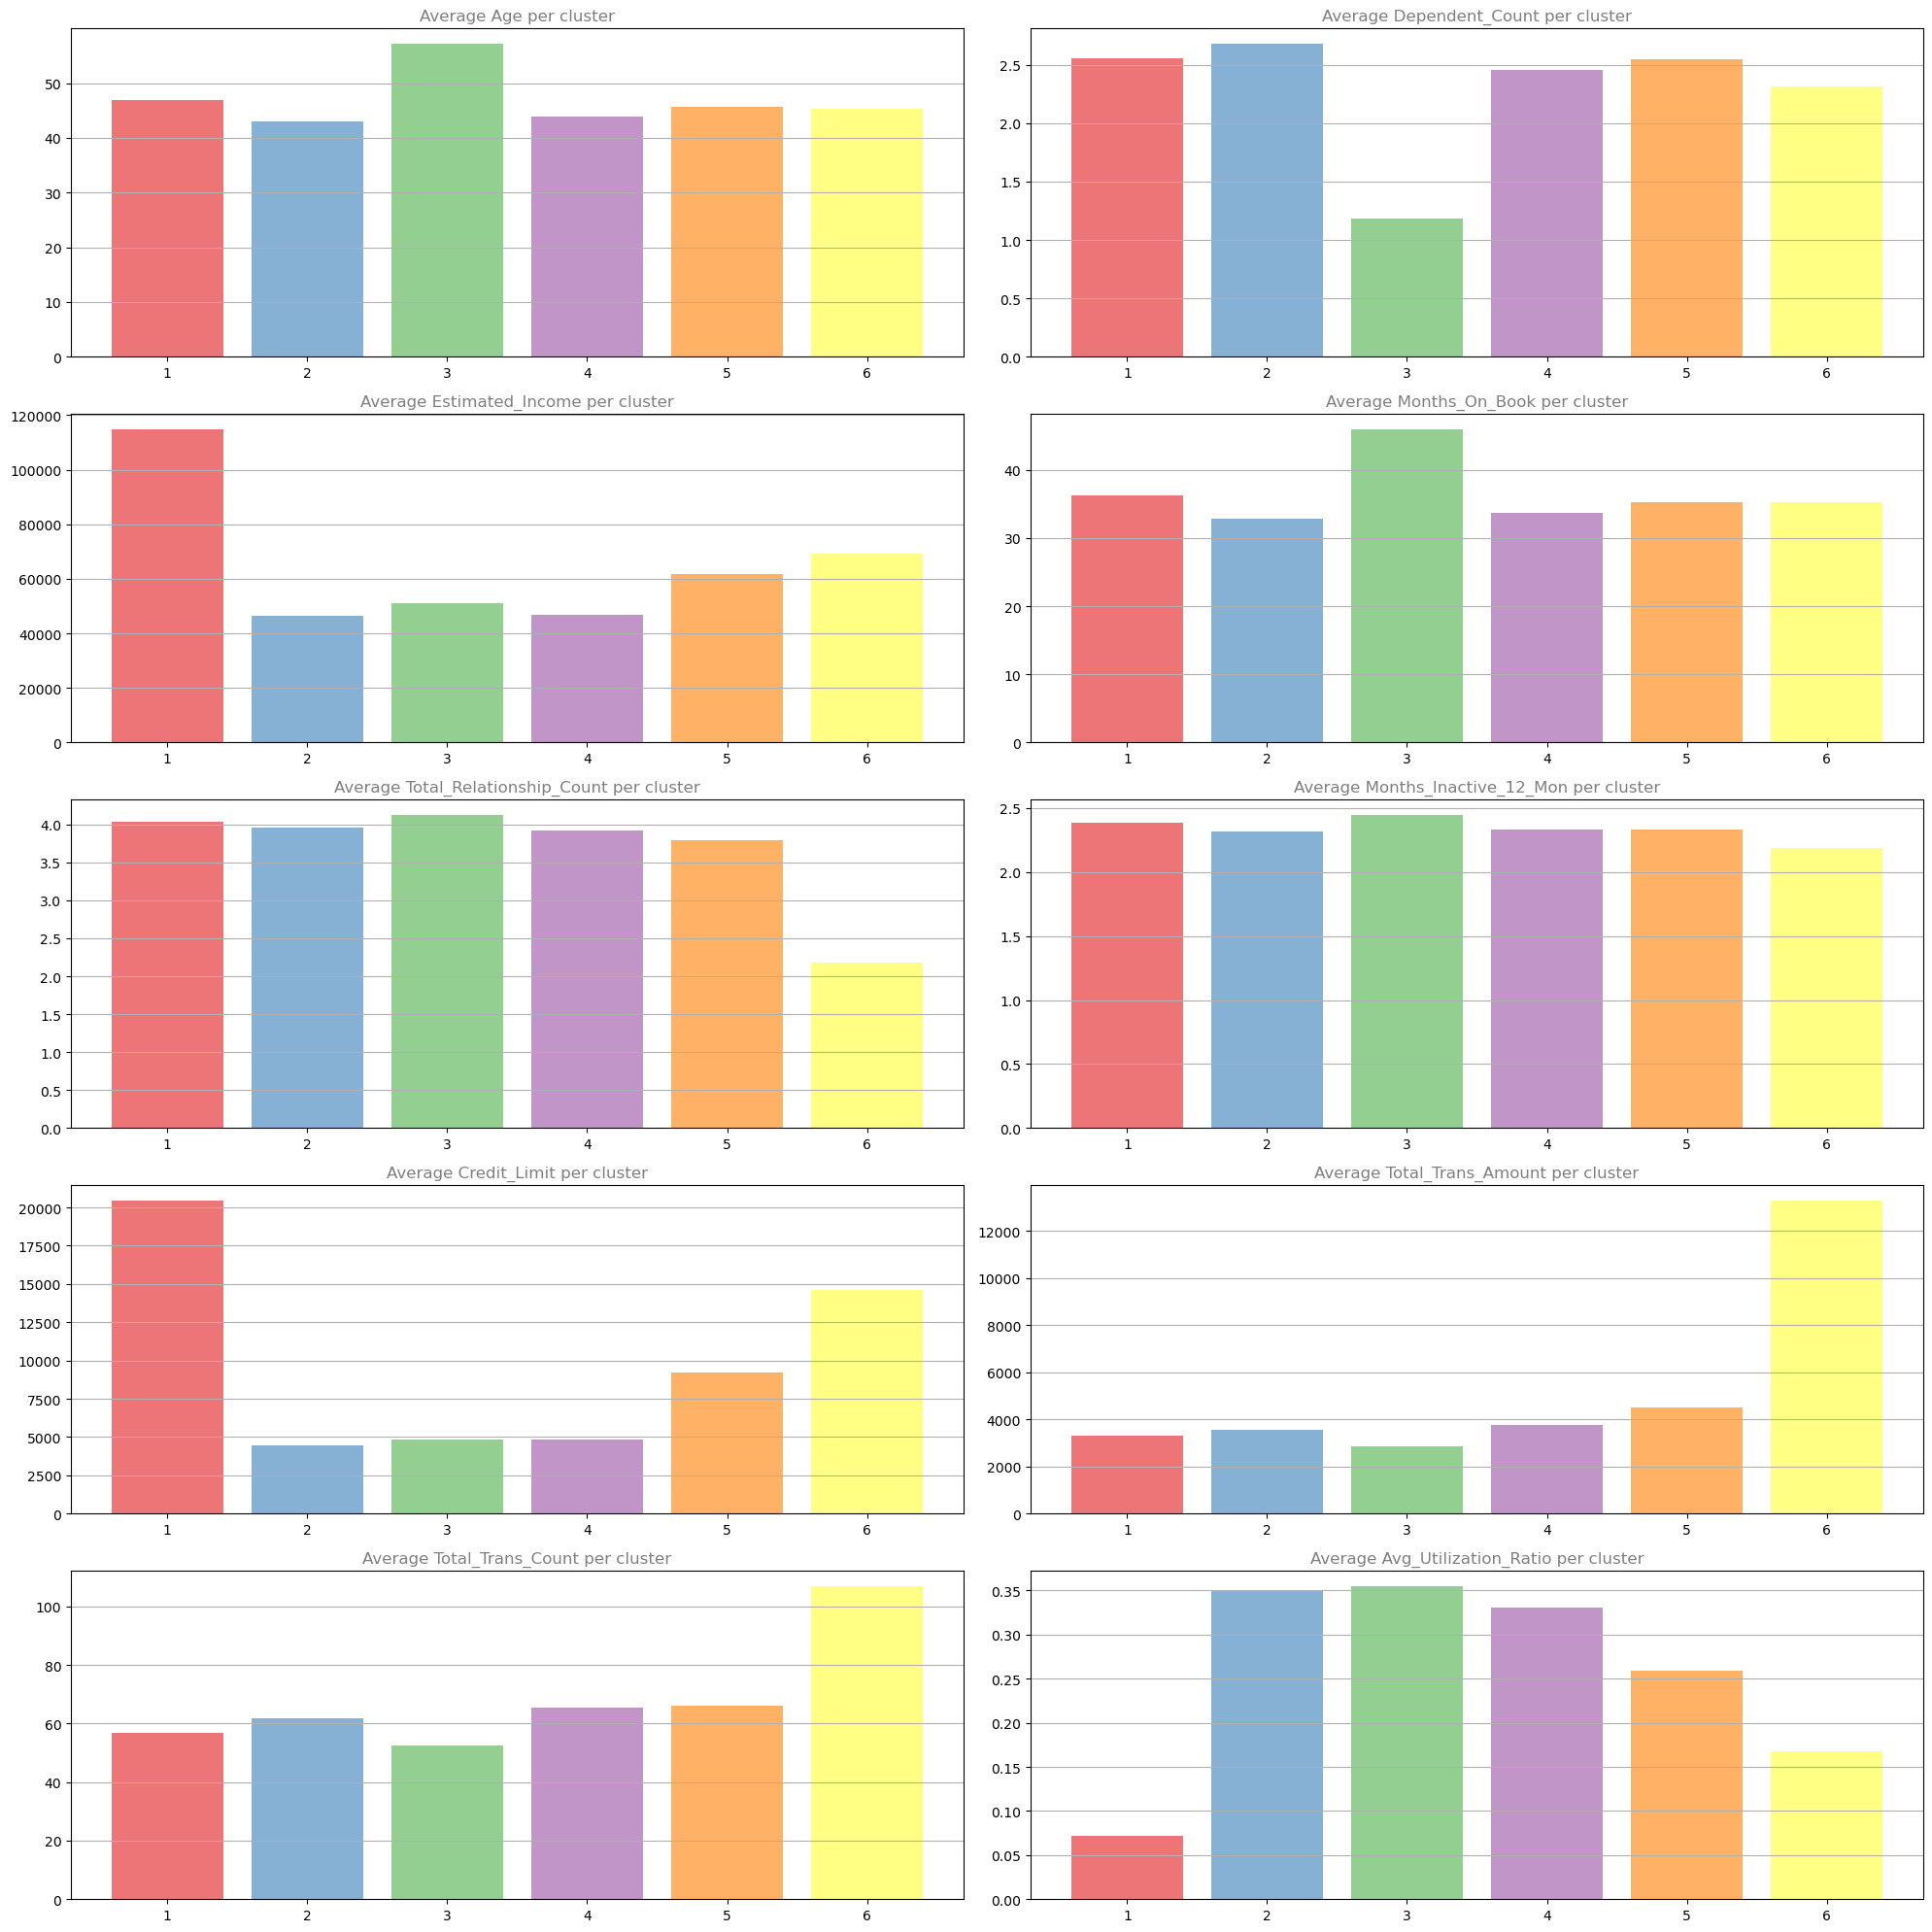

In [19]:
numeric_columns = customer_data.select_dtypes(exclude="object").drop(["customer_id", "CLUSTER"], axis=1).columns

fig = plt.figure(figsize=(20,20))
for i, col in enumerate(numeric_columns):
    c_plot = customer_data.groupby("CLUSTER")[col].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(c_plot.index, c_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {col.title()} per cluster', alpha=0.5)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

For the numerical variables with higher correlations observed earlier, we can use a scatter plot to visualize this correlation by grouping it into clusters and analyzing how the clusters vary across different areas of the chart.

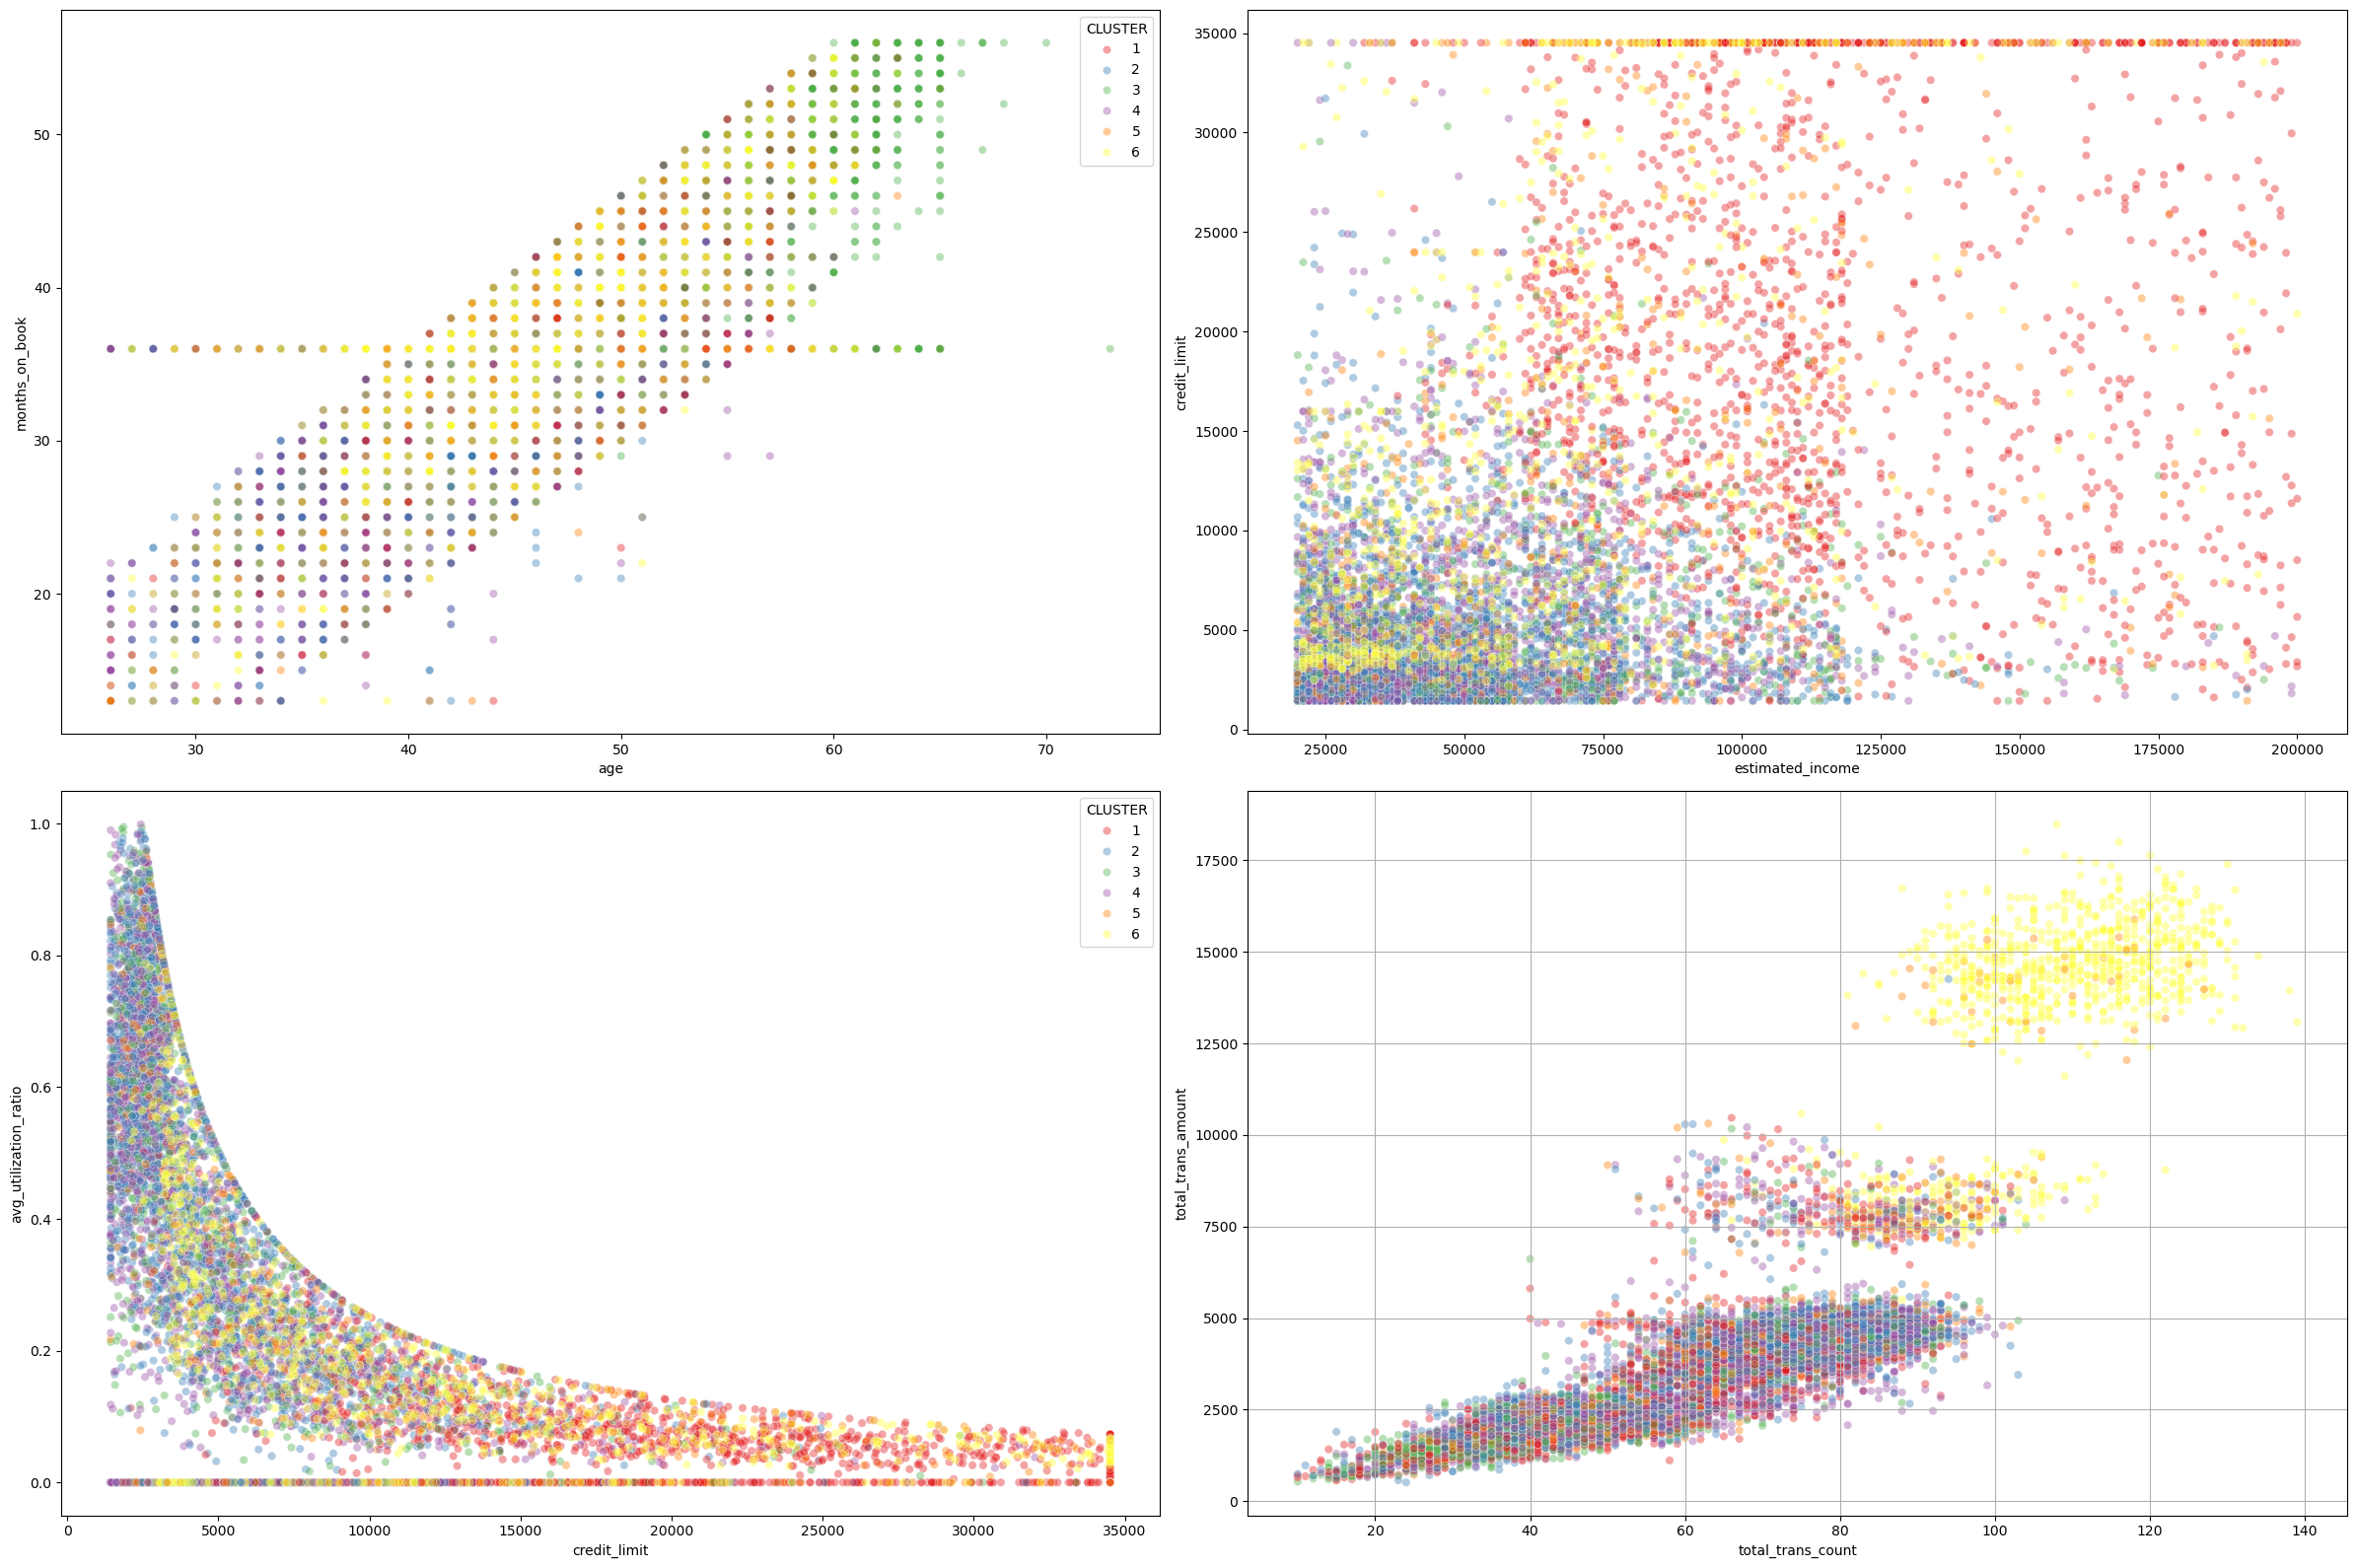

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 16))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customer_data, palette='Set1', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customer_data, palette='Set1', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customer_data, palette='Set1', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customer_data, palette='Set1', alpha=0.4, ax=ax4, legend=False)

plt.grid()
plt.tight_layout()
plt.show()

We can draw some early conclusions based on the numeric variables:

- **Cluster 1**: Contains the highest income earners and has the largest credit limits.
- **Cluster 3**: Comprises the oldest customers, who also have the longest tenure with the company, but exhibit the lowest transaction amounts.
- **Cluster 6**: Includes the most customers with high transaction amounts and high transaction counts.
- **Cluster 2**: Consists of the lowest income earners and has the smallest credit limits. However, they use their credit cards quite frequently using small amounts.

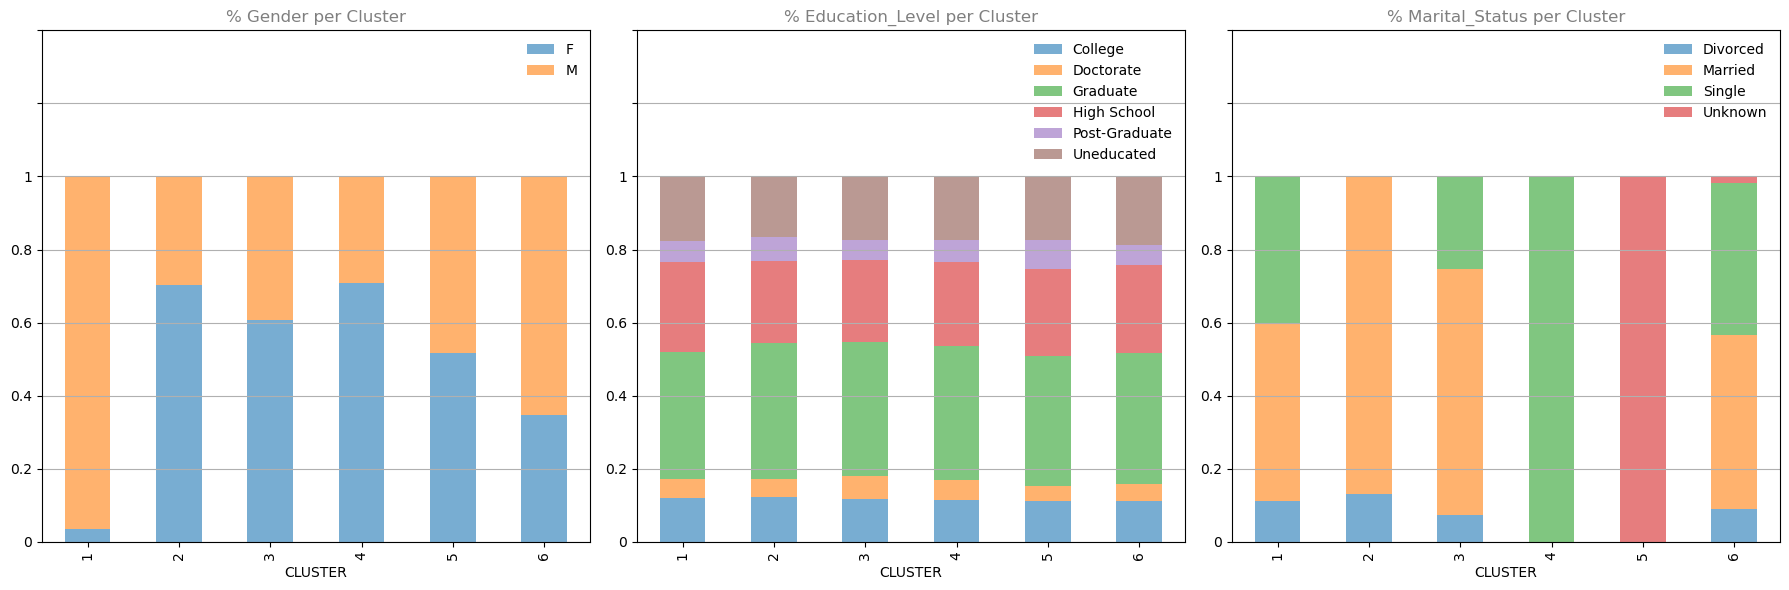

In [38]:
categorical_columns = customer_data.select_dtypes(include=object)

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(categorical_columns):
    plot_df = pd.crosstab(
        index=customer_data["CLUSTER"], columns=customer_data[col],
        values=customer_data[col], aggfunc='size', normalize='index'
    )
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1, "", ""]
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()
    

When analyzing the categorical variables, several notable observations emerge:

- Education levels are evenly distributed across the clusters.
- Cluster 1 consists mainly of males and is the group with the highest income earners and credit limits.
- The marital status of individuals in Cluster 5 is unknown.
- Cluster 4 is composed entirely of single individuals.

## Conclusion

We have segmented our customers into unique clusters that help us better understand and describe them to the company.

#### Cluster 1
**Characteristics:** Predominantly male; highest earners; highest credit limits; lowest transaction counts, credit utilization, and transaction amounts.  
**Insight:** These individuals have high incomes but use their cards infrequently and for lower amounts. There is an opportunity to incentivize them to spend more.

#### Cluster 2
**Characteristics:** Predominantly female; married; lowest earners; lowest credit limits; highest credit utilization with smaller transaction amounts.
**Insight:** This cluster primarily consists of couples with an average of two dependents who frequently use credit cards for small purchases. We have an opportunity to entice them with rewards.

#### Cluster 3
**Characteristics:** Slightly more females; half married, the rest single or divorced; oldest age group; longest-standing customers; highest credit utilization; lowest spending levels.
**Insight:** This group represents older individuals who have been long-time customers. Although they have low credit limits and fewer transactions, they frequently use their cards. We could offer benefits to encourage them to spend more.

#### Cluster 4
**Characteristics:** Single individuals, primarily female; high utilization rate; low limits; low transaction amounts.  
**Insight:** This cluster consists mainly of single (mostly female) individuals who use their cards often but have low credit limits and incomes. They could benefit from an increased credit limit.

#### Cluster 5
**Characteristics:** Gender evenly divided; marital status unknown; high number of dependents; moderate credit utilization and limits.  
**Insight:** This small cluster consists of both men and women with lower credit limits but higher balances.

#### Cluster 6
**Characteristics:** Highest spenders; most transactions; mostly male; utilization below 20%; moderate credit limits.  
**Insight:** These customers are high spenders who maintain low credit utilization, demonstrating good management of credit debt. We suggest incentivizing them to spend more by offering bonus rewards or additional benefits.